In [1]:
import numpy as np
import scipy.constants as c
import matplotlib.pyplot as plt
import util
import axion_mass as m_a
import config
model = config.Model()

In [45]:
m_a.m_a_at_abs_zero_from_marsh(1.0), m_a.m_a_at_abs_zero_from_shellard(1.0)

(6000000000000000.0, 5806498440492653.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


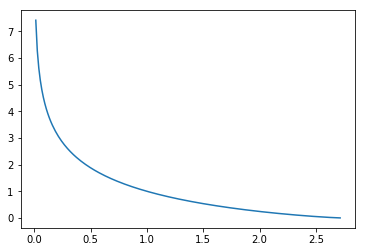

In [24]:
Lambda_over_T = np.linspace(0, 4, 300)
plt.plot(T_over_Lambda, (1 - np.log(Lambda_over_T))**1.2)

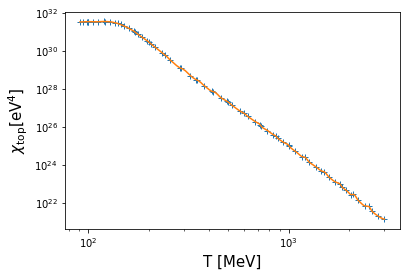

In [3]:
plt.loglog(m_a.T / 1e6, m_a.chi, "+")
T = np.linspace(m_a.T[0], m_a.T[-1], 300)
plt.loglog(T / 1e6, (c.elementary_charge)**4 * m_a.chi_interp(T))

plt.xlabel("T [MeV]", fontsize=15)
plt.ylabel(r"$\chi_\mathrm{top} [\mathrm{eV}^4]$", fontsize=15)
plt.savefig("Plots/chi_of_T.pdf")

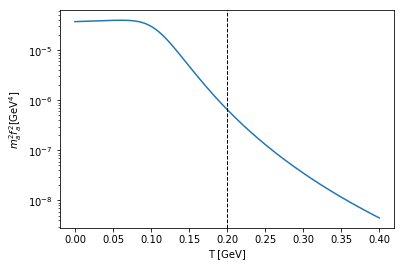

In [41]:
T = np.linspace(0, 400e6, 400)
Lambda = 400e6
m_a_f_a_sq = 1.46e-3 * Lambda**4 * (1 + 0.5*T/Lambda) / (1 + (3.53*T/Lambda)**7.48)
plt.semilogy(T / 1e9, m_a_f_a_sq / 1e9**4)
plt.xlabel("T [GeV]")
plt.ylabel(r"$m_a^2 f_a^2 [\mathrm{GeV}^4]$")
plt.axvline(0.2, color="black", lw=1, linestyle="--")

In [42]:
import importlib
m_a = importlib.reload(m_a)

def make_comparsion_plot(T_min=10**7.8, T_max=None):
    # general constants
    f_a = 1e14 * 1e9
    fig, ax = plt.subplots(figsize=(10, 6))

    if T_max is None:
        T_max = np.max(m_a.T)
    T = np.logspace(np.log10(T_min), np.log10(T_max), 400)

    ##################################### T = 0 #####################################
    ax.loglog(T / 1e6, m_a.m_a_at_abs_zero_from_shellard(f_a) * np.ones(np.size(T)),
            label=r"$m_a(T = 0)$ Shellard", linestyle="-.")

    ##################################### low T from shellard ##############################
    ax.loglog(T / 1e6, m_a.m_a_at_low_T_from_shellard(T, f_a),
            linestyle="-.", label="Shellard low T")

    ##################################### T > Lambda_QCD ###############################
    # fox for high T > Lambda_QCD
    ax.loglog(T / 1e6, m_a.m_a_at_high_T_from_fox(T, f_a, False), "--", label="Fox")
    ax.loglog(T / 1e6, m_a.m_a_at_high_T_from_fox(T, f_a, True), "--", label="Fox corr")

    # shellard for high T
    ax.loglog(T / 1e6, m_a.m_a_at_high_T_from_shellard(T, f_a),
            label="Shellard", linestyle="-.")

    #################################### general lattice result ################################
    ax.loglog(m_a.T / 1e6, m_a.m_a_from_chi(m_a.T, f_a),
            label=r"Borsanyi Lattice $\chi_\mathrm{top}$", linestyle=":", color="black", lw=2)

    ##################################### make the plot ###################################
    ax.axvline(model.Lambda_QCD / 1e6, label=r"$\Lambda_\mathrm{QCD}$", linestyle="-", color="black")
    ax.set_xlabel(r"$T [MeV]$", fontsize=15)
    ax.set_ylabel("m_a(T) / eV", fontsize=15)
    plt.grid()
    ax.legend(loc="lower left", ncol=2)
    plt.xlim(T_min / 1e6, T_max / 1e6)
    plt.tight_layout()

/home/janik/Documents/bachelor/axion_mass.py:55: RuntimeWarning: invalid value encountered in power
  return m_a
/usr/local/lib/python3.6/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


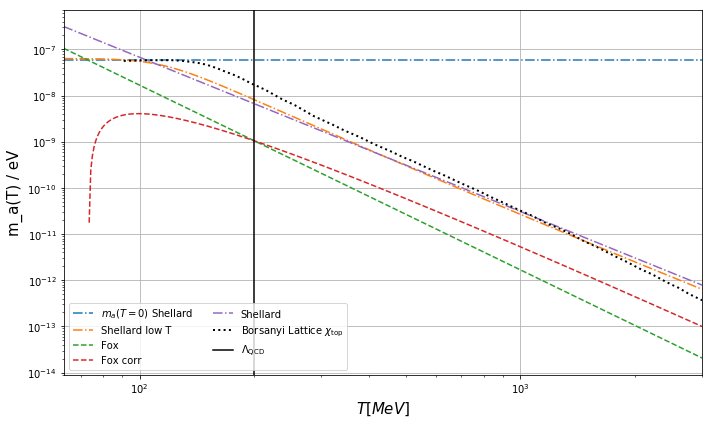

In [37]:
make_comparsion_plot()

(1e-10, 1e-07)

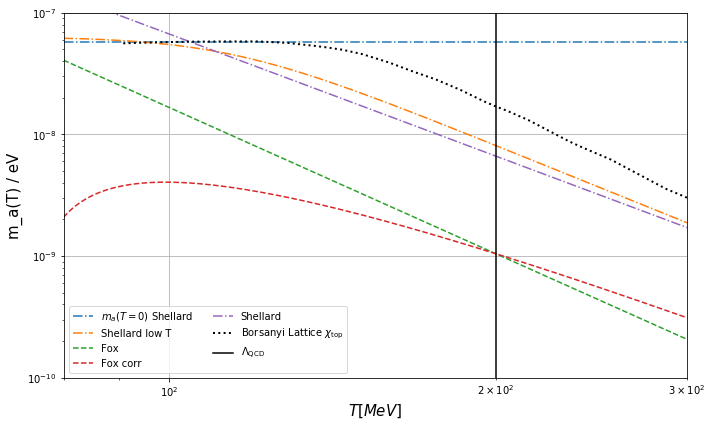

In [40]:
make_comparsion_plot(80e6, 300e6)
plt.ylim(1e-10, 1e-7)

(1e-13, 1e-10)

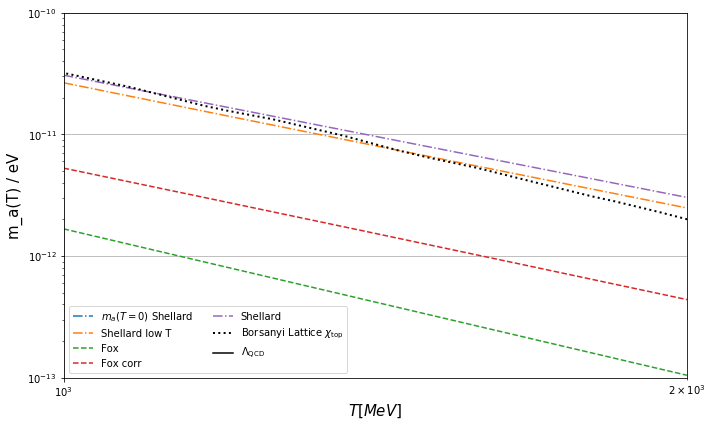

In [44]:
make_comparsion_plot(1000e6, 2000e6)
plt.ylim(1e-13, 1e-10)